<img src="https://drive.google.com/uc?id=1fo5VGc3fDGcrg-9tudhG4BRuXlN7bXgS" alt="header" style="height:200px;">

# Image Analysis

**Quintana Ruiz Ajitzi Ricardo**

**Boleta: 2017631261**

**Grupo: 3CV6**

02 - Image Algebra


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
%load_ext Cython
import requests
from io import BytesIO

**Some Helpful functions**


In [0]:
#Displays an array as an image
def im_show(pic,ip):
    height=pic.shape[0]
    width=pic.shape[1]
    
    print(type(pic))
    channels=1
    if pic.ndim>2:
        channels=3
    #ip="nearest"
    plt.figure(figsize=(10,int(10*float(height)/float(width)) ))
    if channels==1:
        plt.imshow(pic,cmap='gray',interpolation=ip,aspect="auto")
    else:
        plt.imshow(pic,interpolation=ip,aspect="auto")

def im_load(file):
    pic=Image.open(file) #Open the image
    print("Image type:"+str(type(pic))) #Displays the type of image (JPEG, BMP, PNG, GIF, etc)
    pic_arr = np.asarray(pic) #converts the image to an Numpy Array
    print("Dimentions"+str(pic_arr.shape)) #(height,width,#of channels)
    pic_channels=1
    if pic_arr.ndim>2:
        pic_channels=3
    print("Channels:"+str(pic_channels))
    #im_show(pic_arr)
    return pic_arr

def grayscale(pic):
    height=pic.shape[0]
    width=pic.shape[1]
    
    channels=1
    if pic.ndim==3:
        channels=pic.shape[2]
    
    if channels==1:
        return pic

    factor=np.array([0.24,0.65,0.11])
    if channels==4:
        factor=np.array([0.24,0.65,0.11,1])

    pic2=np.dot(pic.astype(dtype=np.float),factor)

    return pic2.astype(dtype=np.uint8)

def noise(img, salt, pepper):
    height=img.shape[0]
    width=img.shape[1]  
    img_r=np.asarray(img.copy(),order="C")
    
    hw=height*width
    
    if salt>0 and salt<=1:
        npixels=int(float(hw)*salt)
        for i in range(npixels):
            x = np.random.randint(0,width,1)
            y = np.random.randint(0,height,1)
            img_r[y[0],x[0]]=255
            
        
    if pepper>0 and pepper<=1:
        npixels=int(float(hw)*pepper)
        for i in range(npixels):
            x = np.random.randint(0,width,1)
            y = np.random.randint(0,height,1)
            img_r[y[0],x[0]]=0
    
    return img_r

def getMinImg(img1,img2):
  if img1.shape[0] >= img2.shape[0] and img1.shape[1] >= img2.shape[1]:
      return img2
  else:
      return img1

def getMaxImg(img1,img2):
  if img1.shape[0] >= img2.shape[0] and img1.shape[1] >= img2.shape[1]:
      return img1
  else:
      return img2

Image type:<class 'PIL.PngImagePlugin.PngImageFile'>
Dimentions(400, 600, 4)
Channels:3
CPU times: user 13.1 ms, sys: 829 µs, total: 13.9 ms
Wall time: 13.9 ms
(400, 600)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Image type:<class 'PIL.PngImagePlugin.PngImageFile'>
Dimentions(244, 297, 4)
Channels:3
CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 3.03 ms
(244, 297)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


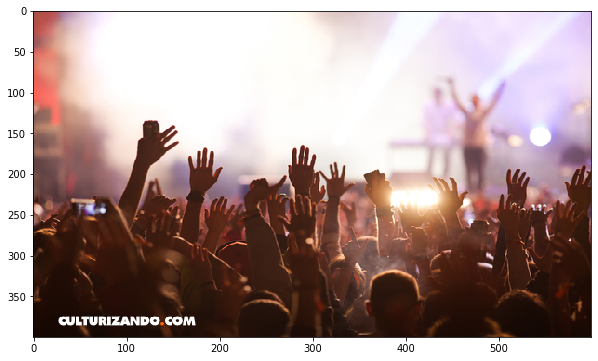

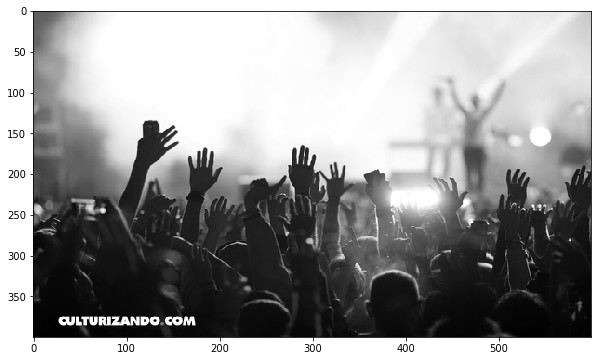

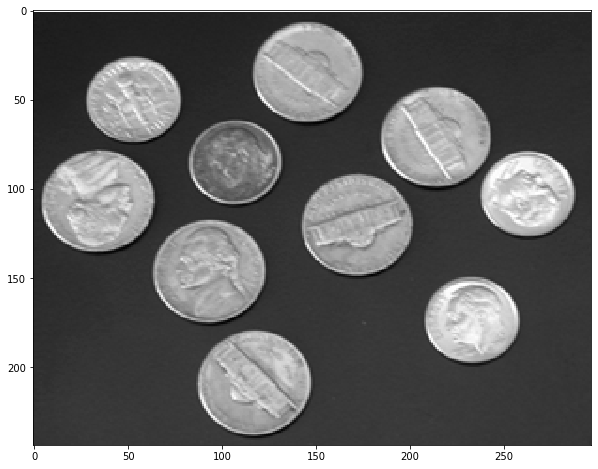

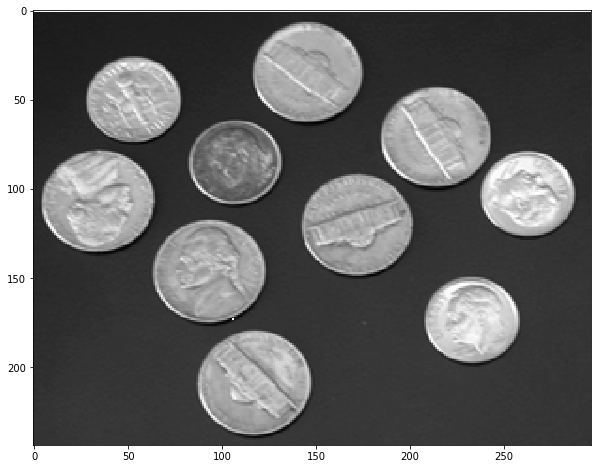

In [31]:
#url="https://drive.google.com/uc?id=1HCVHyrLztG3gCqn5uITCMEcJ0J-t6UDY" #peppers.png
url = "https://drive.google.com/uc?id=19zyR22cAa68mnCUWKiiz8onN3J0tHTA9" #concert
response = requests.get(url)
pic1=im_load(BytesIO(response.content))
%time pic1_gray=grayscale(pic1)
print(pic1_gray.shape)
im_show(pic1,"nearest")
im_show(pic1_gray,"nearest")
url="https://drive.google.com/uc?id=1MYcPu-s08IeC6Pmhnzp7AjGLjALUIq1n" #coins.png
response = requests.get(url)
pic2=im_load(BytesIO(response.content))
%time pic2_gray=grayscale(pic2)
print(pic2_gray.shape)
im_show(pic2,"nearest")
im_show(pic2_gray,"nearest")



## Image by Scalar


Consider the operation of scalar multiplication of pixel values. In this operation, if the value of a pixel in the original image is f [ i, j ], the value of the corresponding pixel in the output image h [ i, j ] is given by:

h [ i,j ] = a ° f [ i,j ] 

where **a** is a real positive number.

<br>

In an image the efect dependes on the value of **a**:

if **a** is higher than 1, the output image is more brihtg.
if **a** is between 0 and 1 the output image is more dark


### Without Cython

In [0]:
def img_byscalar_easy_butwrong(alpha, img1) :    
    
    return alpha*img1


def img_byscalar_bruteforce_nocython(alpha, img1) :    
    height=img1.shape[0]
    width=img1.shape[1]  
        
    hw=height*width

    img_r=np.zeros((height,width),dtype=np.uint8)

    for i in range(height):   #FOR EVERY ROW   
        for j in range(width):   #FOR EVERY COLUMN
            res=alpha*float(img1[i,j])
            if res<0.0:
                res=0.0
            if res>255.0:
                res=255.0
            img_r[i,j]=int(res)
    
    return img_r

def img_byscalar_vectorized_nocython(alpha, img1) :    

    img_r=img1.astype(dtype=np.float)*alpha
    img_r[img_r>255]=255
    
    return img_r.astype(dtype=np.uint8)

### With Cython

In [33]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def img_byscalar_bruteforce_cython(const float alpha, const unsigned char[:,:] img1) :    
    cdef int height=img1.shape[0]
    cdef int width=img1.shape[1]  
    cdef int i
    cdef int j
        
    cdef int hw=height*width

    cdef img_r=np.zeros((height,width),dtype=np.uint8)

    for i in range(height):   #FOR EVERY ROW   
        for j in range(width):   #FOR EVERY COLUMN
            res=alpha*float(img1[i,j])
            if res<0.0:
                res=0.0
            if res>255.0:
                res=255.0
            img_r[i,j]=int(res)
    
    return img_r


def img_byscalar_vectorized_cython(alpha, img1) :    

    img_r=img1.astype(dtype=np.float)*alpha
    img_r[img_r>255]=255
    
    return img_r.astype(dtype=np.uint8)


### Testing

<class 'numpy.ndarray'>
CPU times: user 0 ns, sys: 57 µs, total: 57 µs
Wall time: 60.3 µs
CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 144 ms
CPU times: user 1.52 ms, sys: 979 µs, total: 2.5 ms
Wall time: 2.51 ms
CPU times: user 31.7 ms, sys: 23 µs, total: 31.8 ms
Wall time: 31.9 ms
CPU times: user 2.23 ms, sys: 1.04 ms, total: 3.27 ms
Wall time: 4.06 ms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


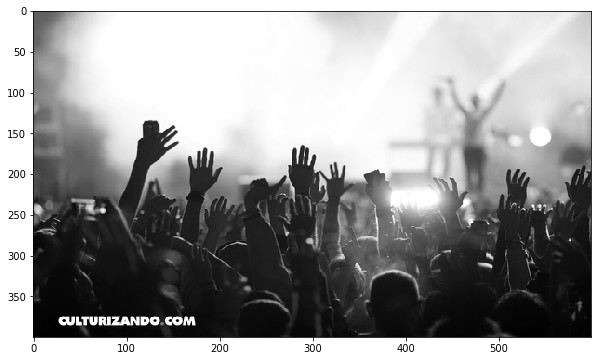

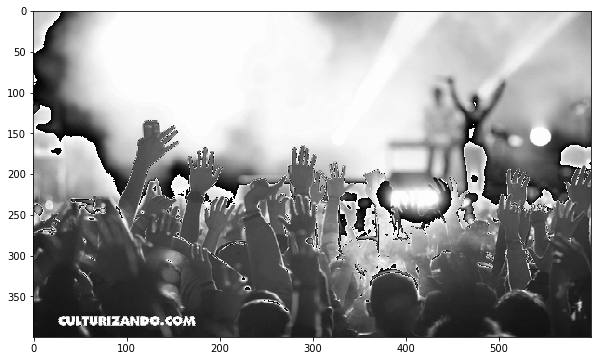

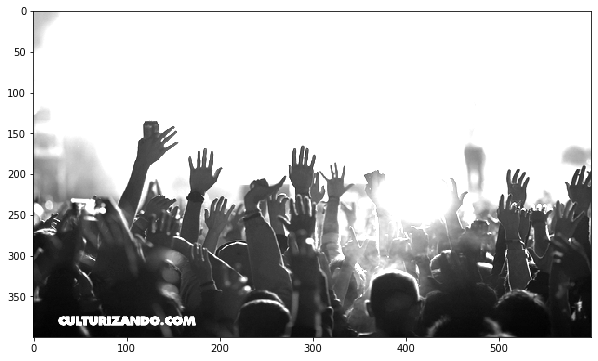

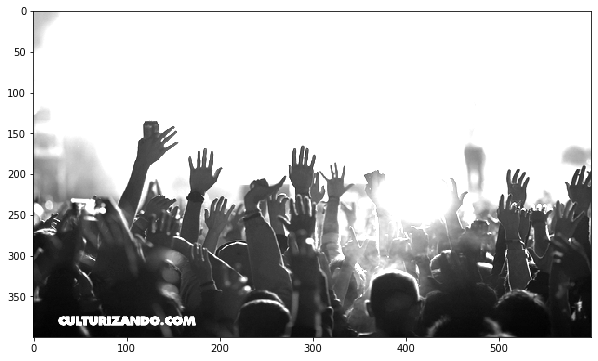

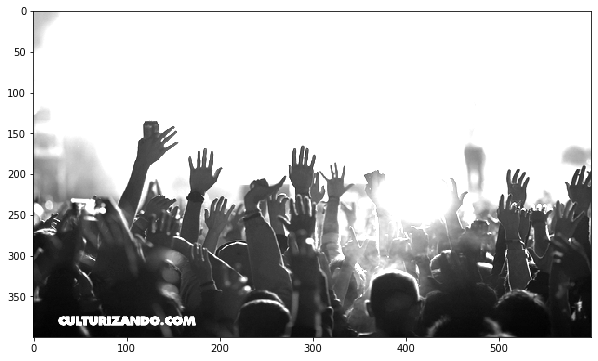

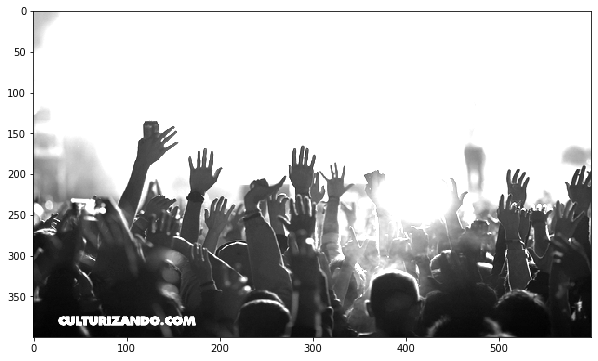

In [34]:
im_show(pic1_gray,"nearest")
alpha=2

%time pic_res1=img_byscalar_easy_butwrong(alpha,pic1_gray)
%time pic_res2=img_byscalar_bruteforce_nocython(alpha,pic1_gray)
%time pic_res3=img_byscalar_vectorized_nocython(alpha,pic1_gray)
%time pic_res4=img_byscalar_bruteforce_cython(alpha,pic1_gray)
%time pic_res5=img_byscalar_vectorized_cython(alpha,pic1_gray)


im_show(pic_res1,"nearest")
im_show(pic_res2,"nearest")
im_show(pic_res3,"nearest")
im_show(pic_res4,"nearest")
im_show(pic_res5,"nearest")


## Image by Image

### Without Cython

In [0]:
def img_byimg_easy_butwrong(img1, img2) :    
    if img1.shape[1] == img2.shape[0]: 
      return np.dot(img1,img2)
    else:
      return "no se pueden multiplicar"


def img_byimg_bruteforce_nocython(img1, img2) :    
    height1=img1.shape[0]
    width1=img1.shape[1]
    height2=img2.shape[0]
    width2=img2.shape[1]

    if width1 != height2:
      return "no se pueden multiplicar"
    
    img_r=np.zeros((height1,width2),dtype=np.uint8)

    for i in range(width1):   
        for j in range(width2):  
            res = 0
            for k in range (height2):
              res += float(img1[i,k])*float(img2[k,j])
            img_r[i,j] = int(res)
    
    return img_r

def img_byimg_vectorized_nocython(img1, img2) :    

    img_r=np.dot(img1.astype(dtype=np.float),img2.astype(dtype=np.float))
    img_r[img_r>255]=255
    
    return img_r.astype(dtype=np.uint8)

## Image add Image

Two images must have an equal number of pixel to be added. The sum of two images A and B will be a image which has the same number of pixels as do A and B. The sum of A and B, denoted A + B, is computed by adding corresponding elements of A and B:


\begin{aligned}\mathbf {A} +\mathbf {B} &={\begin{bmatrix}a_{11}&a_{12}&\cdots &a_{1n}\\a_{21}&a_{22}&\cdots &a_{2n}\\\vdots &\vdots &\ddots &\vdots \\a_{m1}&a_{m2}&\cdots &a_{mn}\\\end{bmatrix}}+{\begin{bmatrix}b_{11}&b_{12}&\cdots &b_{1n}\\b_{21}&b_{22}&\cdots &b_{2n}\\\vdots &\vdots &\ddots &\vdots \\b_{m1}&b_{m2}&\cdots &b_{mn}\\\end{bmatrix}}\\&={\begin{bmatrix}a_{11}+b_{11}&a_{12}+b_{12}&\cdots &a_{1n}+b_{1n}\\a_{21}+b_{21}&a_{22}+b_{22}&\cdots &a_{2n}+b_{2n}\\\vdots &\vdots &\ddots &\vdots \\a_{m1}+b_{m1}&a_{m2}+b_{m2}&\cdots &a_{mn}+b_{mn}\\\end{bmatrix}}\\\end{aligned}


In the case of the images, we seen the image added more bright than the original

### Without Cython

In [0]:
def img_addimg_easy_butwrong(img1, img2) :     
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])),dtype=np.uint8)
    img_r[:min(img1.shape[0],img2.shape[0]),:min(img1.shape[1],img2.shape[1])] = getMinImg(img1,img2) 
    return img_r+getMaxImg(img1,img2)

def img_addimg_bruteforce_nocython(img1, img2) : 
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])),dtype=np.uint8) 
    height1=img1.shape[0]
    width1=img1.shape[1]
    height2=img2.shape[0]
    width2=img2.shape[1]

    for i in range(max(height1,height2)):   
        for j in range(max(width1,width2)):
              if i >= min(height1,height2):
                img_r[i,j] = getMaxImg(img1,img2)[i,j]
              elif j >= min(width1,width2):  
                img_r[i,j] = getMaxImg(img1,img2)[i,j]
              else:  
                res = float(img1[i,j]) + float(img2[i,j])
                if res > 255:
                  res = 255
                img_r[i,j] = res
    
    return img_r

def img_addimg_vectorized_nocython(img1, img2) :    
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])))
    img_r[:min(img1.shape[0],img2.shape[0]),:min(img1.shape[1],img2.shape[1])] = getMinImg(img1,img2)
    img_r2=img_r.astype(dtype=np.float)+getMaxImg(img1,img2).astype(dtype=np.float)
    img_r2[img_r2>255]=255
    
    return img_r2.astype(dtype=np.uint8)

### With Cython

In [36]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def getMinImg_cython(img1,img2):
  if img1.shape[0] >= img2.shape[0] and img1.shape[1] >= img2.shape[1]:
      return img2
  else:
      return img1

def getMaxImg_cython( img1, img2):
  if img1.shape[0] >= img2.shape[0] and img1.shape[1] >= img2.shape[1]:
      return img1
  else:
      return img2

def img_addimg_bruteforce_cython(const unsigned char[:,:] img1,const unsigned char[:,:] img2 ) :    
    cdef int height1=img1.shape[0]
    cdef int width1=img1.shape[1]  
    cdef int height2=img2.shape[0]
    cdef int width2=img2.shape[1]
    cdef int maxH = height1 if height1 > height2 else height2 
    cdef int maxW = width1 if width1 > width2 else width2
    cdef int minH = height2 if height1 > height2 else height1 
    cdef int minW = width2 if width1 > width2 else width1
    cdef int i
    cdef int j

    cdef img_r=np.zeros((maxH,maxW),dtype=np.uint8)

    for i in range(maxH):   #FOR EVERY ROW   
        for j in range(maxW):   #FOR EVERY COLUMN
            if i >= minH:
              img_r[i,j] = getMaxImg_cython(img1,img2)[i,j]
            elif j >= minW:  
              img_r[i,j] = getMaxImg_cython(img1,img2)[i,j]
            else:  
              res = float(img1[i,j]) + float(img2[i,j])
              if res > 255.0:
                res = 255.0
              img_r[i,j] = int(res)
    
    return img_r


def img_addimg_vectorized_cython(img1, img2) :    
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])))
    img_r[:min(img1.shape[0],img2.shape[0]),:min(img1.shape[1],img2.shape[1])] = getMinImg_cython(img1,img2)
    img_r2=img_r.astype(dtype=np.float)+getMaxImg_cython(img1,img2).astype(dtype=np.float)
    img_r2[img_r2>255]=255
    
    return img_r2.astype(dtype=np.uint8)


### Testing

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CPU times: user 96 µs, sys: 14 µs, total: 110 µs
Wall time: 114 µs
CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 258 ms
CPU times: user 794 µs, sys: 3.96 ms, total: 4.75 ms
Wall time: 4.77 ms
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 232 ms
CPU times: user 3.67 ms, sys: 819 µs, total: 4.49 ms
Wall time: 4.53 ms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


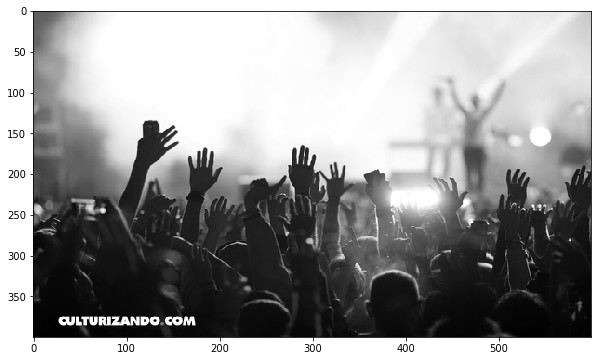

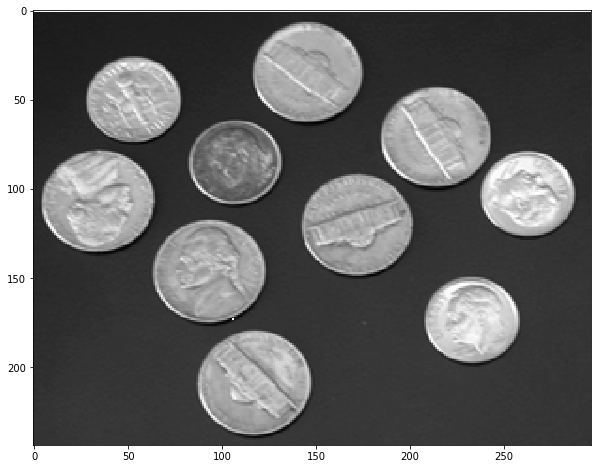

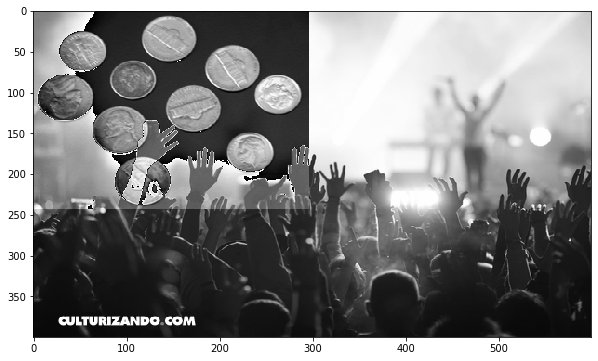

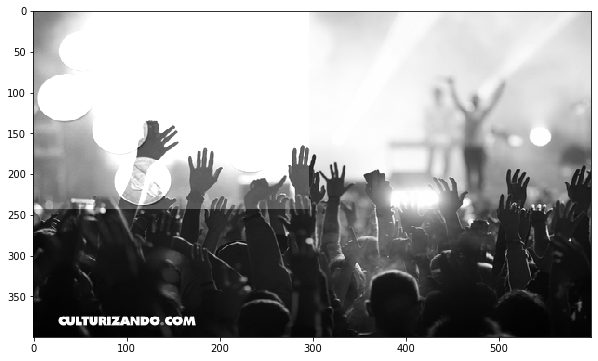

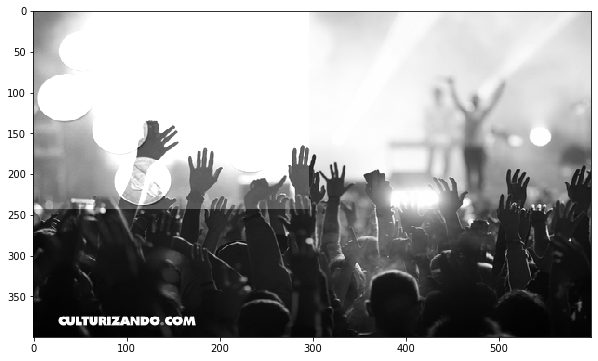

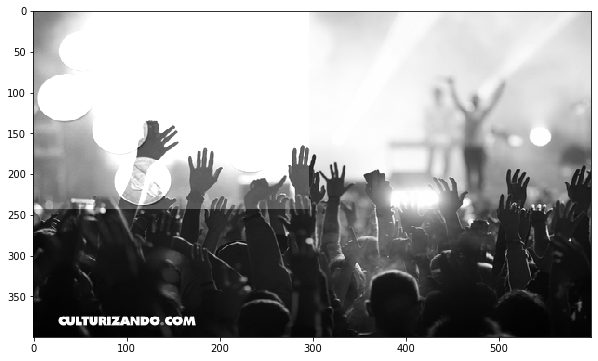

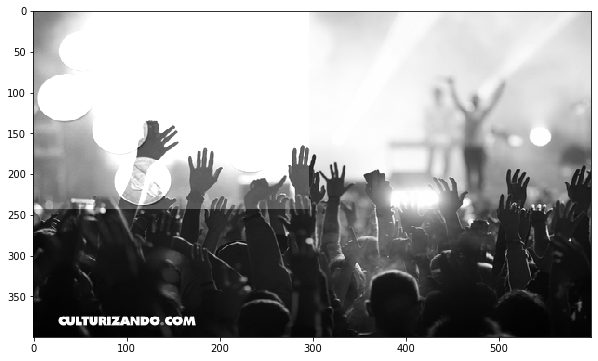

In [37]:
im_show(pic1_gray,"nearest")
im_show(pic2_gray,"nearest")

%time pic_res1=img_addimg_easy_butwrong(pic1_gray,pic2_gray)
%time pic_res2=img_addimg_bruteforce_nocython(pic1_gray,pic2_gray)
%time pic_res3=img_addimg_vectorized_nocython(pic1_gray,pic2_gray)
%time pic_res4=img_addimg_bruteforce_cython(pic1_gray,pic2_gray)
%time pic_res5=img_addimg_vectorized_cython(pic1_gray,pic2_gray)


im_show(pic_res1,"nearest")
im_show(pic_res2,"nearest")
im_show(pic_res3,"nearest")
im_show(pic_res4,"nearest")
im_show(pic_res5,"nearest")

## Image substracted Image

Two matrices must have an equal number of pixels to be substracted. The sum of two images A and B will be a image which has the same number of pixels as do A and B. The sum of A and B, denoted A - B, is computed by adding corresponding elements of A and B:


\begin{aligned}\mathbf {A} -\mathbf {B} &={\begin{bmatrix}a_{11}&a_{12}&\cdots &a_{1n}\\a_{21}&a_{22}&\cdots &a_{2n}\\\vdots &\vdots &\ddots &\vdots \\a_{m1}&a_{m2}&\cdots &a_{mn}\\\end{bmatrix}}+{\begin{bmatrix}b_{11}&b_{12}&\cdots &b_{1n}\\b_{21}&b_{22}&\cdots &b_{2n}\\\vdots &\vdots &\ddots &\vdots \\b_{m1}&b_{m2}&\cdots &b_{mn}\\\end{bmatrix}}\\&={\begin{bmatrix}a_{11}-b_{11}&a_{12}-b_{12}&\cdots &a_{1n}-b_{1n}\\a_{21}-b_{21}&a_{22}-b_{22}&\cdots &a_{2n}-b_{2n}\\\vdots &\vdots &\ddots &\vdots \\a_{m1}-b_{m1}&a_{m2}-b_{m2}&\cdots &a_{mn}-b_{mn}\\\end{bmatrix}}\\\end{aligned}


In the case of the images, we seen the image substracted more dark than the original

### Without Cython

In [0]:
def img_minusimg_easy_butwrong(img1, img2) :     
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])),dtype=np.uint8)
    img_r[:min(img1.shape[0],img2.shape[0]),:min(img1.shape[1],img2.shape[1])] = getMinImg(img1,img2) 
    return img_r-getMaxImg(img1,img2)

def img_minusimg_bruteforce_nocython(img1, img2) : 
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])),dtype=np.uint8) 
    height1=img1.shape[0]
    width1=img1.shape[1]
    height2=img2.shape[0]
    width2=img2.shape[1]

    for i in range(max(height1,height2)):   
        for j in range(max(width1,width2)):
              if i >= min(height1,height2):
                img_r[i,j] = getMaxImg(img1,img2)[i,j]
              elif j >= min(width1,width2):  
                img_r[i,j] = getMaxImg(img1,img2)[i,j]
              else:  
                res = float(img1[i,j]) - float(img2[i,j])
                if res < 0:
                  res = 0
                img_r[i,j] = res
    
    return img_r

def img_minusimg_vectorized_nocython(img1, img2) :    
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])))
    img_r[:min(img1.shape[0],img2.shape[0]),:min(img1.shape[1],img2.shape[1])] = getMinImg(img1,img2)
    img_r2=getMaxImg(img1,img2).astype(dtype=np.float)-img_r.astype(dtype=np.float)
    img_r2[img_r2<0]=0
    
    return img_r2.astype(dtype=np.uint8)

### With Cython

In [39]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def getMinImg_cython(img1,img2):
  if img1.shape[0] >= img2.shape[0] and img1.shape[1] >= img2.shape[1]:
      return img2
  else:
      return img1

def getMaxImg_cython( img1, img2):
  if img1.shape[0] >= img2.shape[0] and img1.shape[1] >= img2.shape[1]:
      return img1
  else:
      return img2

def img_minusimg_bruteforce_cython(const unsigned char[:,:] img1,const unsigned char[:,:] img2 ) :    
    cdef int height1=img1.shape[0]
    cdef int width1=img1.shape[1]  
    cdef int height2=img2.shape[0]
    cdef int width2=img2.shape[1]
    cdef int maxH = height1 if height1 > height2 else height2 
    cdef int maxW = width1 if width1 > width2 else width2
    cdef int minH = height2 if height1 > height2 else height1 
    cdef int minW = width2 if width1 > width2 else width1
    cdef int i
    cdef int j

    cdef img_r=np.zeros((maxH,maxW),dtype=np.uint8)

    for i in range(maxH):   #FOR EVERY ROW   
        for j in range(maxW):   #FOR EVERY COLUMN
            if i >= minH:
              img_r[i,j] = getMaxImg_cython(img1,img2)[i,j]
            elif j >= minW:  
              img_r[i,j] = getMaxImg_cython(img1,img2)[i,j]
            else:  
              res = float(img1[i,j]) - float(img2[i,j])
              if res < 0.0:
                res = 0.0
              img_r[i,j] = int(res)
    
    return img_r


def img_minusimg_vectorized_cython(img1, img2) :    
    img_r=np.zeros((max(img1.shape[0],img2.shape[0]),max(img1.shape[1],img2.shape[1])))
    img_r[:min(img1.shape[0],img2.shape[0]),:min(img1.shape[1],img2.shape[1])] = getMinImg_cython(img1,img2)
    img_r2=getMaxImg_cython(img1,img2).astype(dtype=np.float)-img_r.astype(dtype=np.float)
    img_r2[img_r2<0]=0
    
    return img_r2.astype(dtype=np.uint8)


### Testing

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CPU times: user 108 µs, sys: 0 ns, total: 108 µs
Wall time: 113 µs
CPU times: user 240 ms, sys: 861 µs, total: 240 ms
Wall time: 241 ms
CPU times: user 3.35 ms, sys: 1.93 ms, total: 5.28 ms
Wall time: 5.31 ms
CPU times: user 239 ms, sys: 978 µs, total: 240 ms
Wall time: 240 ms
CPU times: user 5.17 ms, sys: 94 µs, total: 5.26 ms
Wall time: 5.7 ms
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


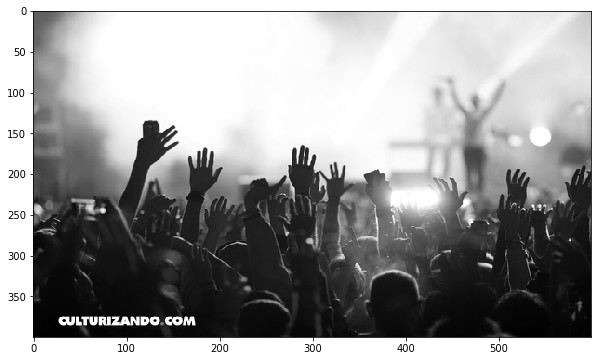

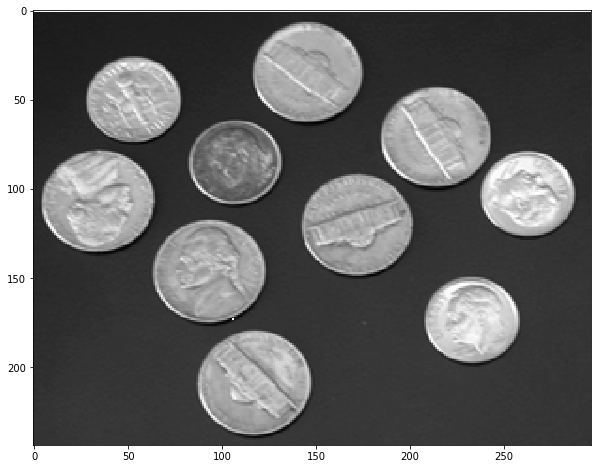

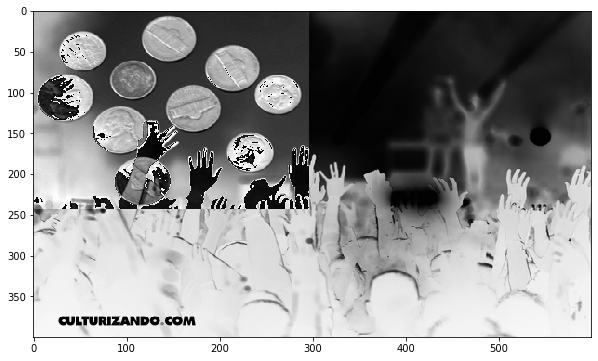

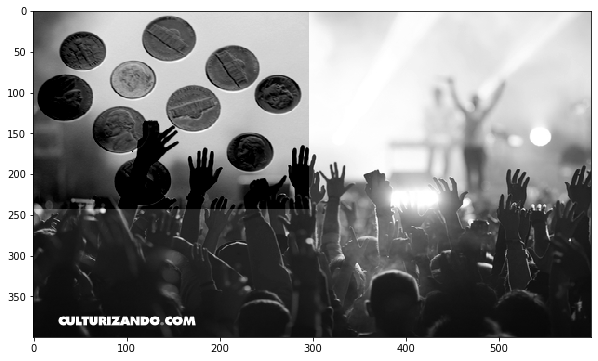

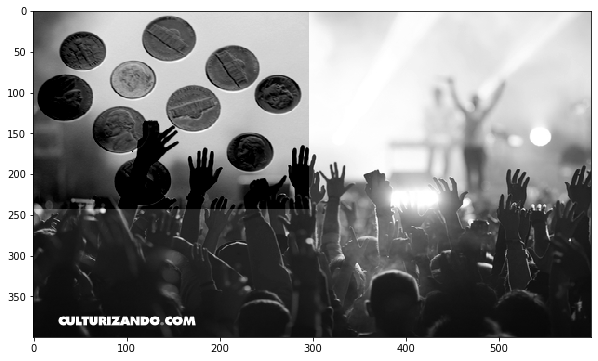

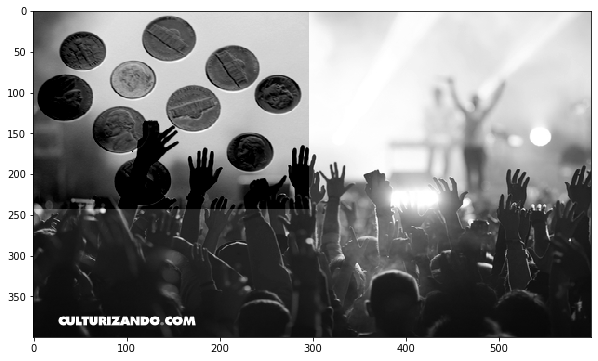

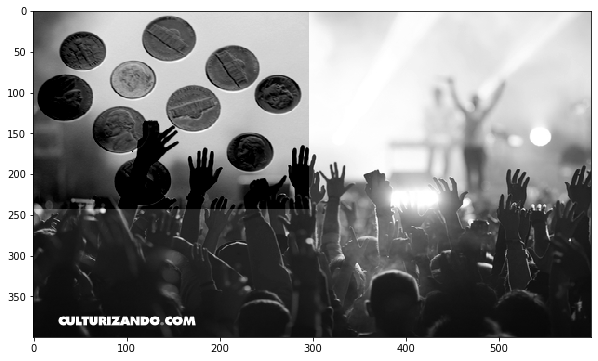

In [40]:
im_show(pic1_gray,"nearest")
im_show(pic2_gray,"nearest")

%time pic_res1=img_minusimg_easy_butwrong(pic1_gray,pic2_gray)
%time pic_res2=img_minusimg_bruteforce_nocython(pic1_gray,pic2_gray)
%time pic_res3=img_minusimg_vectorized_nocython(pic1_gray,pic2_gray)
%time pic_res4=img_minusimg_bruteforce_cython(pic1_gray,pic2_gray)
%time pic_res5=img_minusimg_vectorized_cython(pic1_gray,pic2_gray)


im_show(pic_res1,"nearest")
im_show(pic_res2,"nearest")
im_show(pic_res3,"nearest")
im_show(pic_res4,"nearest")
im_show(pic_res5,"nearest")

## Negative Image

Negatives are normally used to make positive prints on photographic paper by projecting the negative onto the paper with a photographic enlarger or making a contact print. The paper is also darkened in proportion to its exposure to light, so a second reversal results which restores light and dark to their normal order.

### Without Cython

In [0]:
def negative_image_bruteforce_nocython(img):
  img_r = img.copy()
  for x in range (img.shape[0]):
    for y in range (img.shape[1]):
        img_r[x,y] = 255 -  img[x,y] 
  return img_r

def negative_image_vectorized_nocython(img) :    
    return 255 - img 

### With Cython

In [42]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def negative_image_bruteforce_cython(const unsigned char[:,:] img) :    
    cdef int height=img.shape[0]
    cdef int width=img.shape[1]  
    cdef int i
    cdef int j
    cdef img_r=np.zeros((height,width),dtype=np.uint8)

    for i in range(height):   #FOR EVERY ROW   
        for j in range(width):   #FOR EVERY COLUMN
            img_r[i,j]=255 - img[i,j]
    
    return img_r

def negative_image_vectorized_cython(img):
  return 255 - img


### Testing

<class 'numpy.ndarray'>
CPU times: user 623 ms, sys: 688 µs, total: 624 ms
Wall time: 624 ms
CPU times: user 661 µs, sys: 0 ns, total: 661 µs
Wall time: 512 µs
CPU times: user 25.3 ms, sys: 0 ns, total: 25.3 ms
Wall time: 25.3 ms
CPU times: user 86 µs, sys: 0 ns, total: 86 µs
Wall time: 75.1 µs
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


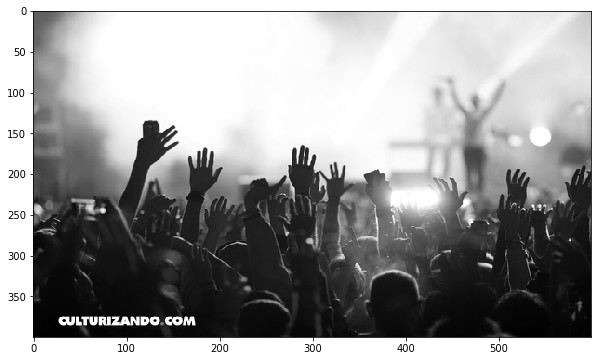

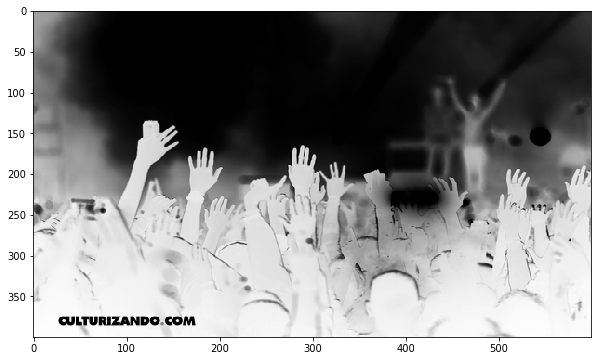

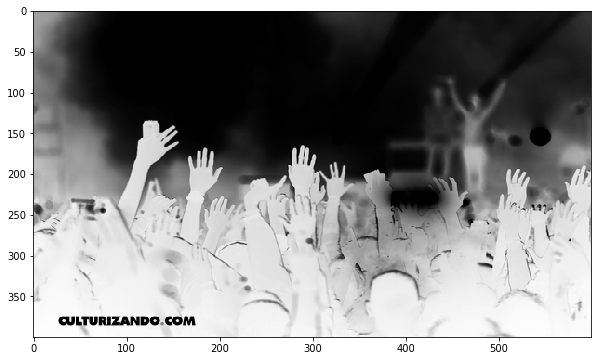

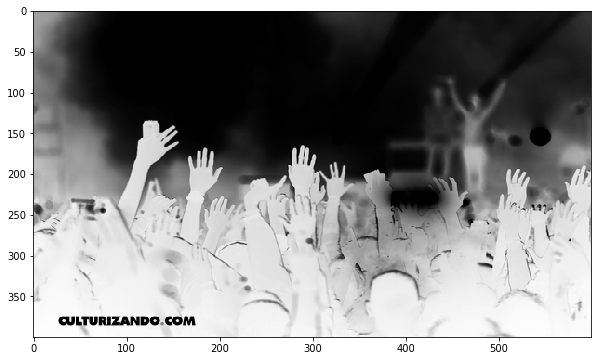

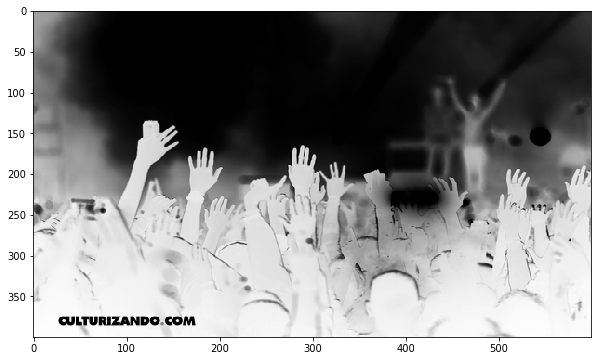

In [43]:
im_show(pic1_gray,"nearest")

%time pic_res1=negative_image_bruteforce_nocython(pic1_gray)
%time pic_res2=negative_image_vectorized_nocython(pic1_gray)
%time pic_res3=negative_image_bruteforce_cython(pic1_gray)
%time pic_res4=negative_image_vectorized_cython(pic1_gray)

im_show(pic_res1,"nearest")
im_show(pic_res2,"nearest")
im_show(pic_res3,"nearest")
im_show(pic_res4,"nearest")

## Convolution Mask

The convolution matrix filter uses a first matrix that is the image that will be treated. The image is a two-dimensional collection of pixels in a rectangle coordinate. The kernel used depends on the desired effect.

The GIMP uses 5x5 or 3x3 matrices. We will consider only 3x3 matrices, they are the most used and are sufficient for the desired effects. If all the values of a kernel are selected to zero, the system will consider it as a 3x3 matrix.

The filter examines, successively, each pixel of the image. For each of them, which we will call "initial pixels", multiply the value of this pixel and the value of the surrounding 8 by the corresponding value of the kernel. The result is then added, and the initial pixel is regulated at this final resulting value.

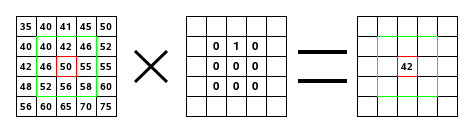

### With Cython

In [44]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def convolve(image, mask):
    A = 0
    mask = np.flipud(np.fliplr(mask))    # Flip the mask
    output = image.copy()          # dilation output
    va = (mask.shape[1] - 1)/2
    image_padded = np.zeros((image.shape[0] + (mask.shape[1]-1), image.shape[1] + (mask.shape[1]-1)))   
    image_padded[int(va):int(-va), int(va):int(-va)] = image.copy()

    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            for xmask in range(mask.shape[1]):
                for ymask in range(mask.shape[0]):
                    A += (image_padded[y+ymask, x+xmask] * mask[ymask,xmask])
            if A > 255:
                output[y,x] = 255
            elif A < 0:
                output[y,x] = 0
            else:
                output[y,x] = A
            A = 0
            
    return output

### Testing

<class 'numpy.ndarray'>
CPU times: user 1.88 s, sys: 5.28 ms, total: 1.89 s
Wall time: 1.89 s
<class 'numpy.ndarray'>


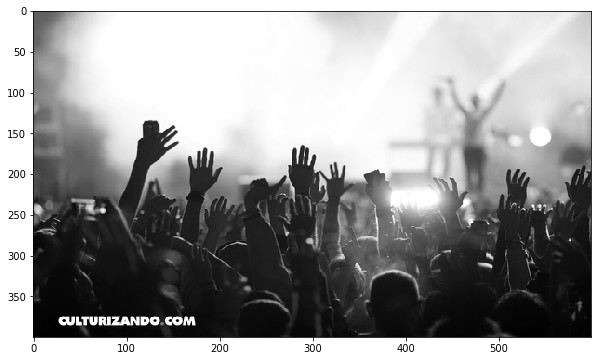

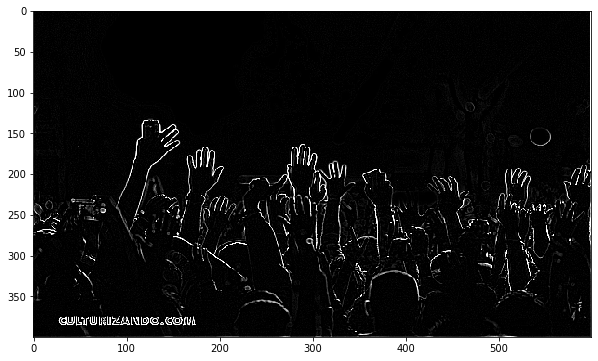

In [45]:
mask = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

im_show(pic1_gray,"nearest")

%time pic_res1=convolve(pic1_gray,mask)

im_show(pic_res1,"nearest")

## Salt and Pepper noise

Image type:<class 'PIL.PngImagePlugin.PngImageFile'>
Dimentions(512, 512, 3)
Channels:3
CPU times: user 9.68 ms, sys: 0 ns, total: 9.68 ms
Wall time: 9.77 ms
(512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CPU times: user 3.28 s, sys: 5.82 ms, total: 3.28 s
Wall time: 3.28 s
<class 'numpy.ndarray'>


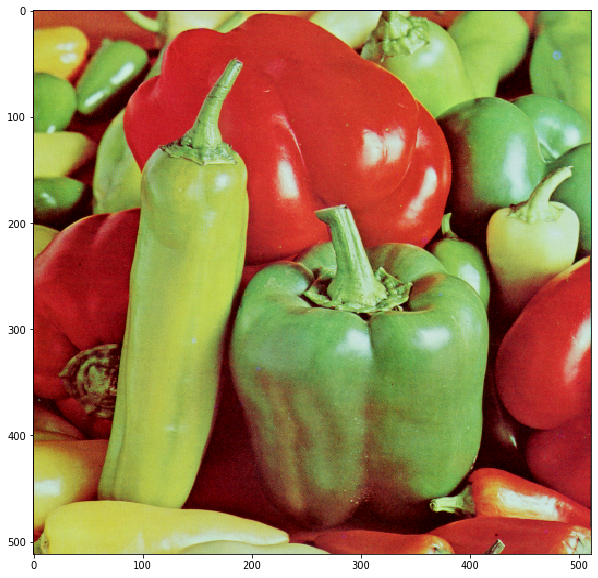

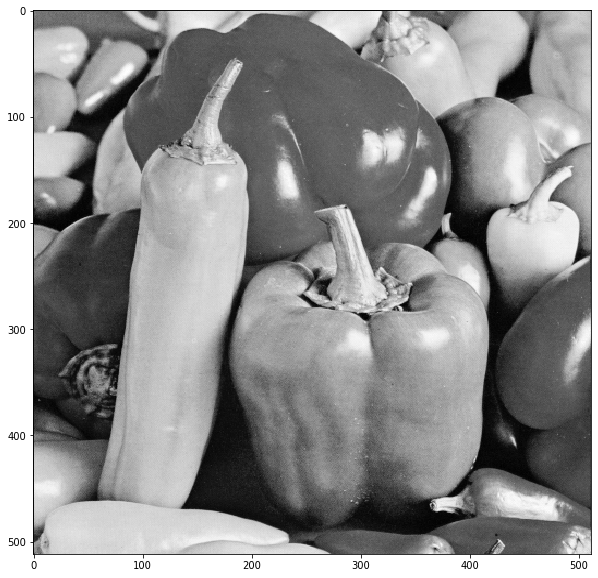

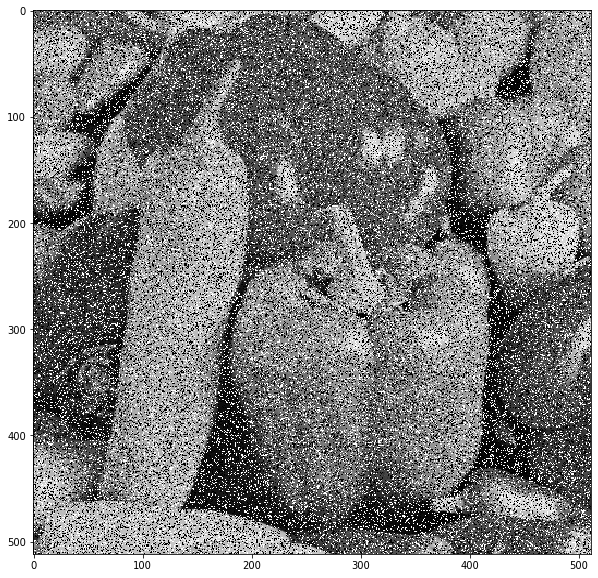

In [0]:
filename2="peppers.png" #The File name
pic2=im_load(filepath+filename2)
%time pic2_gray=grayscale(pic2)
print(pic2_gray.shape)
im_show(pic2,"nearest")
im_show(pic2_gray,"nearest")

salt=0.2
pepper=0.2

%time pic2_gray_noised=noise(pic2_gray,salt,pepper)
im_show(pic2_gray_noised,"nearest")